In [12]:
import json
from datetime import datetime, time, timedelta
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import math
from typing import *


Enable plot UI backend

In [13]:
# %matplotlib tk

Update <u>PARAMETERS.json</u> with **current** date and time

In [14]:
file_path = "PARAMETERS.json" 

# Get the current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(file_path) == 0:
    print(f"Error: The file '{file_path}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(file_path, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2024-12-26 22:59:01.


In [15]:
print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'segment_1.csv', 'output.csv', 'single_data_analysis.ipynb', 'Plots', 'PARAMETERS.json', '__pycache__', 'tmp.csv', 'all_data_analysis.ipynb']


In [16]:
CONVERT_UNIX_TO_DATE = False

In [17]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Save the DataFrame to CSV
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")




def merge_dfs(ALL_DFS):
    result = pd.concat(ALL_DFS, ignore_index=True)
    print(type(result))
    return result
    
    
# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop


ALL_DFS = []

while _cnt <= 20:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_df = pd.DataFrame(snapshot_data_list)
        
        # Convert UNIX timestamps in 'dateStored' column to human-readable format
        if CONVERT_UNIX_TO_DATE != False:
            unix_to_datetime_pandas(snapshot_df, 'dateStored')
            
            
        ALL_DFS.append(snapshot_df)
        #save_to_csv(snapshot_df, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")

        
        
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1
    

merged_dfs = merge_dfs(ALL_DFS)
print(type(merged_dfs))
    
# Save the DataFrame to CSV only if it's not empty
save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", f"all_vehicle_responses.csv")

print("Process complete!")



**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!


Visualize data **dispersion**

In [18]:
merged_dfs.dtypes
print(merged_dfs)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  38.034458  23.748177  1716382625000       0.0       0.0   
1              1  38.034598  23.748143  1716383081000       6.0       0.0   
2              1  38.034633  23.748132  1716383105000       0.0       0.0   
3              1  38.034667  23.748163  1716383333000       0.0       0.0   
4              1  38.034713  23.748122  1716383724000       8.0       0.0   
...          ...        ...        ...            ...       ...       ...   
26247         20  38.034748  23.746115  1716389383000      39.0       0.0   
26248         20  38.034988  23.745633  1716389387000      34.0       0.0   
26249         20  38.035463  23.745138  1716389388000      33.0       0.0   
26250         20  38.035783  23.744812  1716389389000      31.0       0.0   
26251         20  38.036093  23.744623  1716389390000      28.0       0.0   

       engineVoltage  
0                0.0  
1                0.0  
2     

In [19]:
PLOT_FOLDER_PATH = './Plots/'

In [20]:
len(ALL_DFS)

20

2592
56
79
52
241
93
7238
315
4342
23
91
93
85
62
10395
40
129
89
139
98


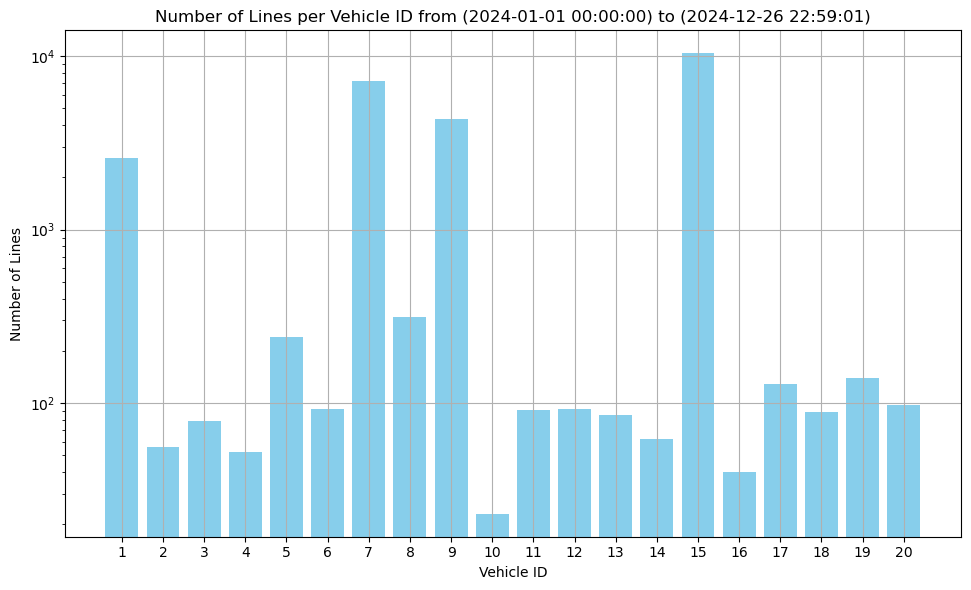

In [24]:
#print(len(merged_dfs['vehicleId']))


unique_veh_ids = []
vehicle_rows = []
for df in ALL_DFS:
    unique_veh_ids.append(df['vehicleId'].values[0])
    vehicle_rows.append(len(df))
    
    print(len(df))
    
    
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_veh_ids, vehicle_rows,color='skyblue')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Lines')
plt.title(f'Number of Lines per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
plt.xticks(unique_veh_ids)
plt.tight_layout()
plt.grid()

# Set a logarithmic scale for better visualization of large variations
plt.yscale("log")


# Construct the full path for saving the plot
plot_file_path = os.path.join(PLOT_FOLDER_PATH, 'vehicle_line_counts.png')
# Save the plot
plt.savefig(plot_file_path, format='png')
# Show the plot
plt.show()



2) Create 2 columns for datetime readable for Humans and for time alone


In [22]:
# Load the CSV file into a DataFrame
VEHICLE_15_PATH = "../../DataSets/API_Responses/Vehicle_Data/Vehicle_15_response.csv"
df = pd.read_csv(VEHICLE_15_PATH)

# Convert the 'dateStored' column to datetime format
df['dateStoredHuman']       = df['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
df['dateOnlyStoredHuman']   = df['dateStoredHuman'].dt.date  # Extract the date only
df['timeOnly']              = df['dateStoredHuman'].dt.time  # Extract the time only

# Sort the DataFrame by 'dateStored' in ascending order
DATA_SORTED                 = df.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                    = DATA_SORTED['lat']
long_clmn                   = DATA_SORTED['lng']
date_stored                 = DATA_SORTED['dateStored']

#! Drop temp columns
df = df.drop(columns=['dateStoredHuman'])


# Save the modified DataFrame back to the CSV
df.to_csv(VEHICLE_15_PATH, index=False)

# Check the first few rows of the sorted data
print(DATA_SORTED.head())

   vehicleId        lat        lng     dateStored  velocity  odometer  \
0         15  38.034933  23.748265  1716383302000       0.0       0.0   
1         15  38.034833  23.747995  1716383303000       1.0       0.0   
2         15  38.034692  23.748035  1716383339000       0.0       0.0   
3         15  38.034720  23.748038  1716383716000       8.0       0.0   
4         15  38.034725  23.748063  1716383722000       6.0       0.0   

   engineVoltage dateOnlyStoredHuman  timeOnly     dateStoredHuman  
0            0.0          2024-05-22  16:08:22 2024-05-22 16:08:22  
1            0.0          2024-05-22  16:08:23 2024-05-22 16:08:23  
2            0.0          2024-05-22  16:08:59 2024-05-22 16:08:59  
3            0.0          2024-05-22  16:15:16 2024-05-22 16:15:16  
4            0.0          2024-05-22  16:15:22 2024-05-22 16:15:22  


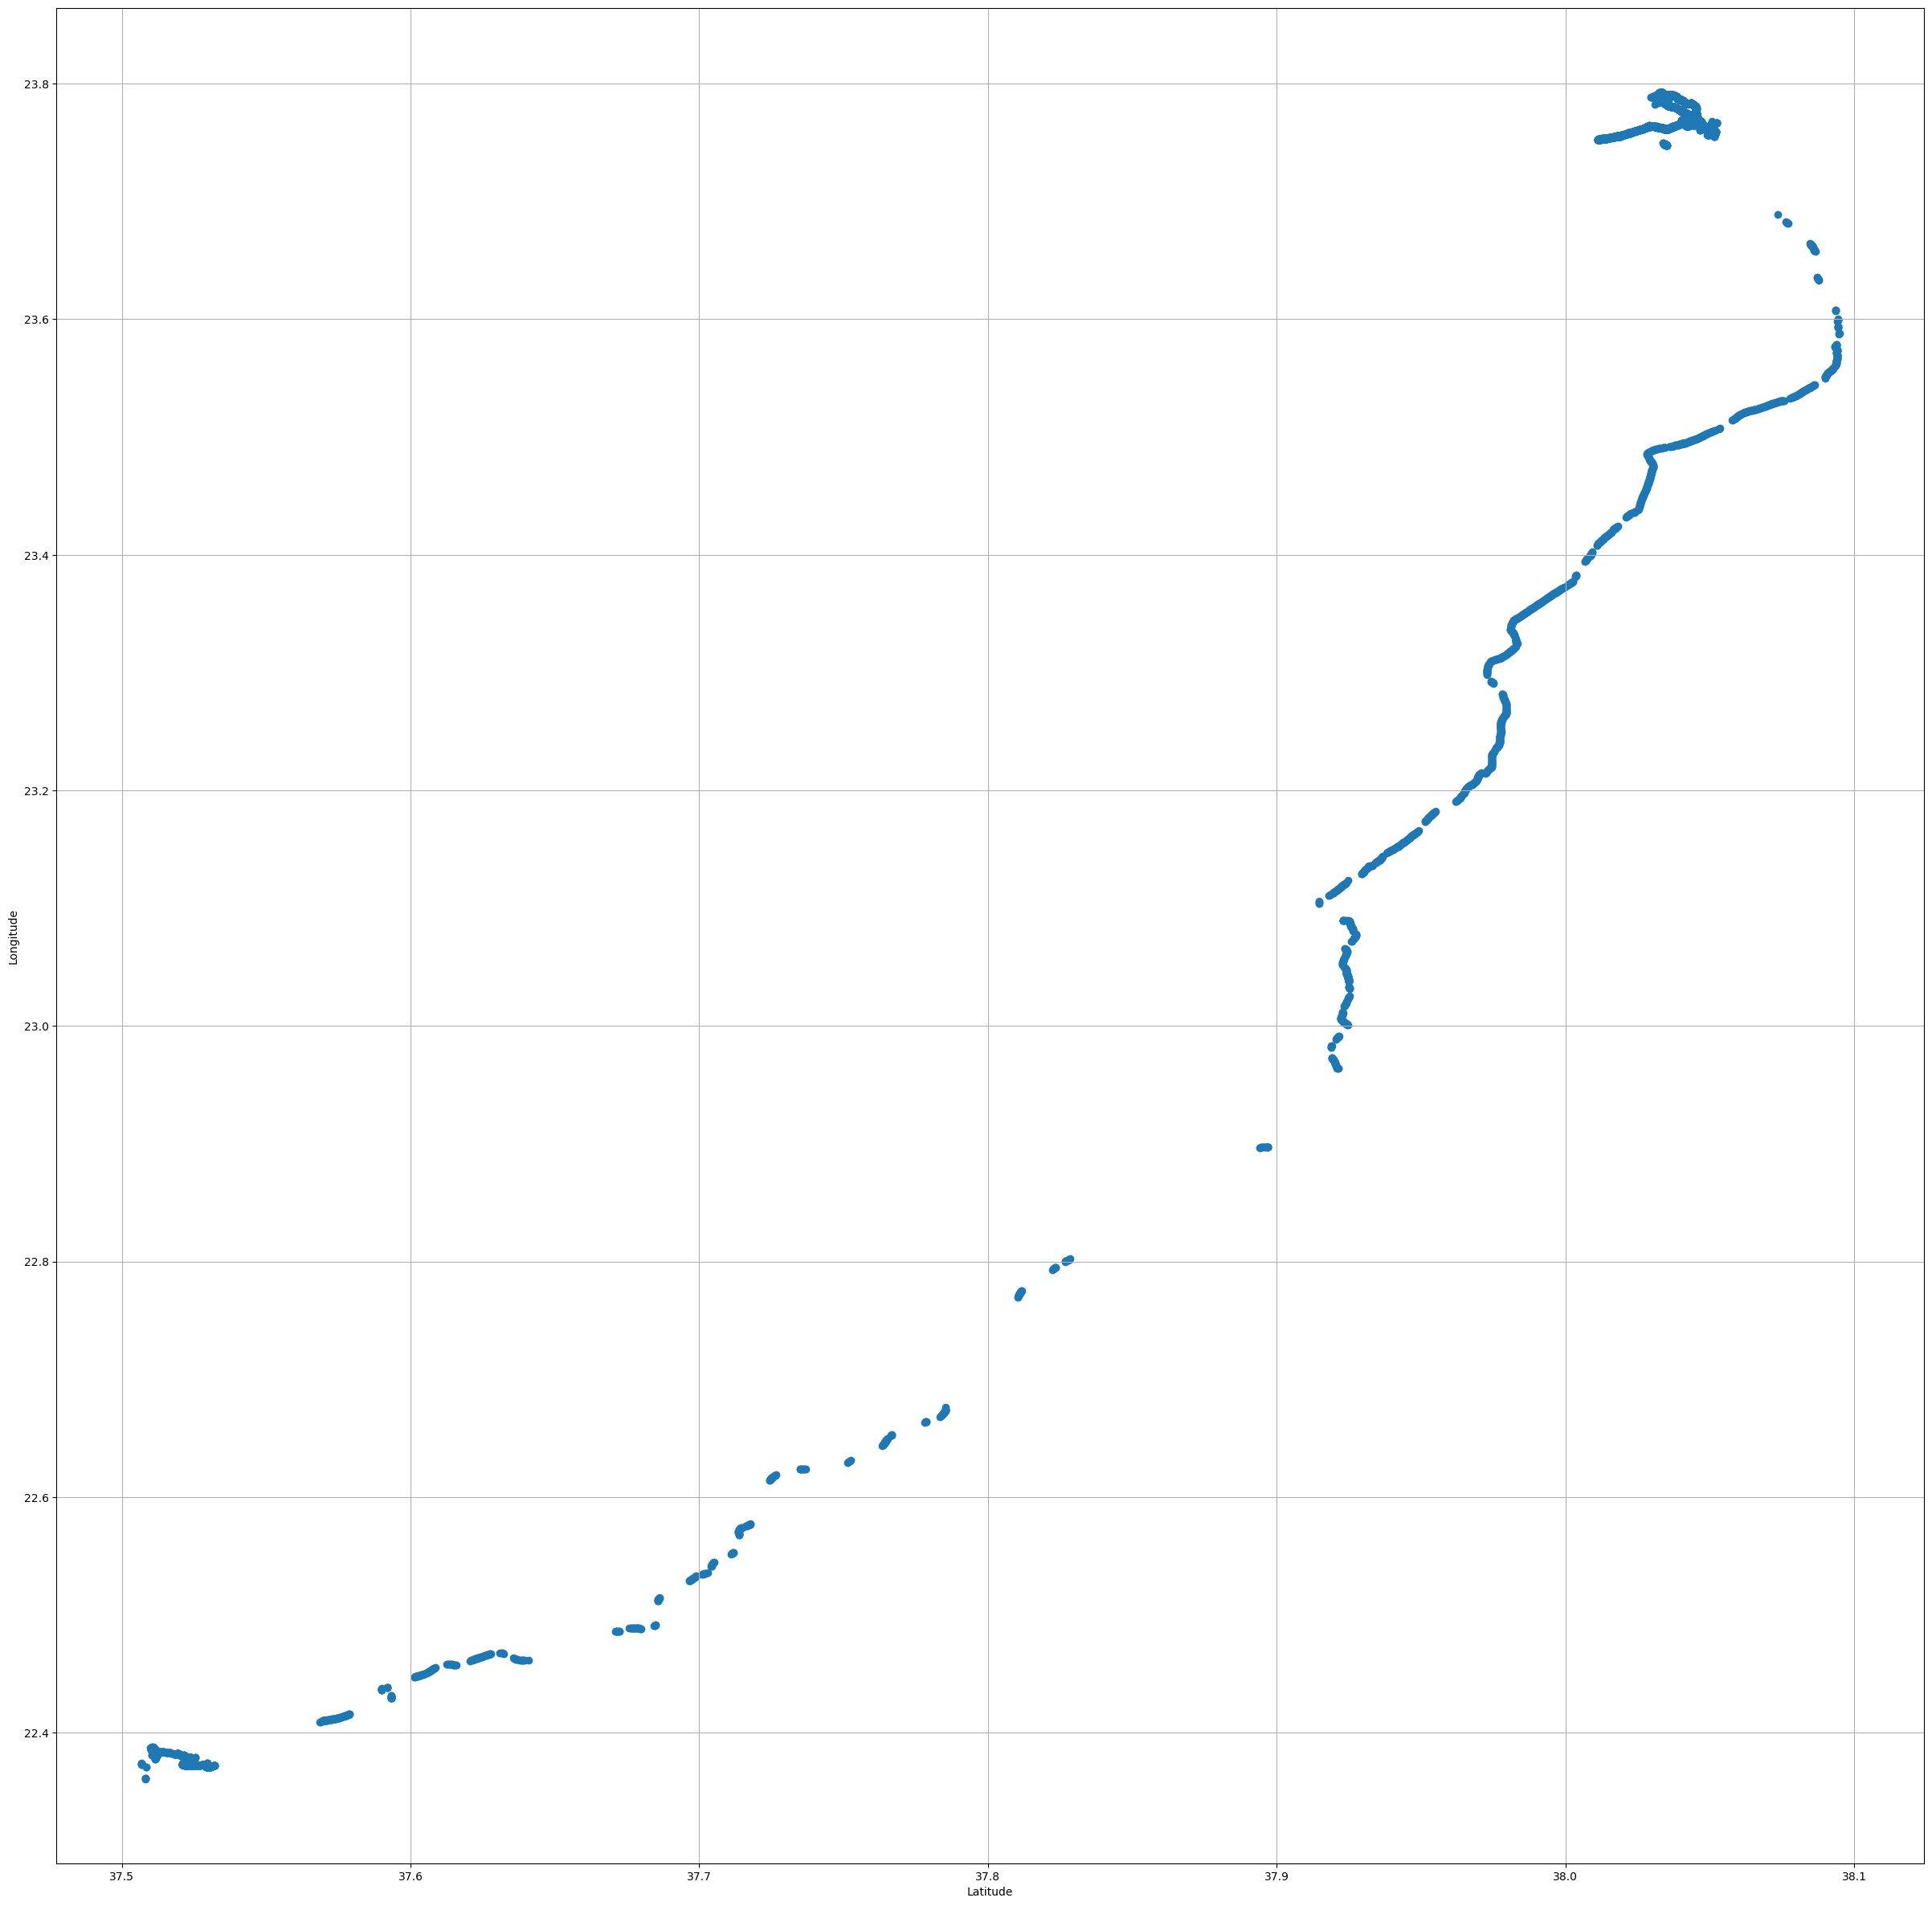

In [23]:
plt.figure(figsize=(30, 30))
# plt.title(f'from {date_stored.iloc[0].strftime("%Y-%m-%d")} to {date_stored.iloc[-1].strftime("%Y-%m-%d")}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')


# Turn off offset notation
plt.gca().ticklabel_format(useOffset=False)

plt.grid()
plt.scatter(lat_clmn, long_clmn)
# plt.plot(lat_clmn, long_clmn, color='r')

plt.show()